<center><h2>ALTeGraD 2024<br>Lab Session 1: HAN</h2><h3>Hierarchical Attention Network Using GRU</h3> 8 / 10 / 2024<br> Dr. Guokan Shang, Yang Zhang<br><br>


<b>Student name:</b> [fill me]


</center>
In this lab, you will get familiar with recurrent neural networks (RNNs), self-attention, and the HAN architecture <b>(Yang et al. 2016)</b> using PyTorch. In this architecture, sentence embeddings are first individually produced, and a document embedding is then computed from the sentence embeddings.<br>
<b>The deadline for this lab is October 15, 2024 11:59 PM.</b> More details about the submission and the architecture for this lab can be found in the handout PDF.


### = = = = =  Attention Layer = = = = =
In thi section, you will fill the gaps in the code to implement the self-attention layer. This layer will be used later to define the HAN architecture. The basic idea behind attention is that rather than considering the last annotation $h_T$ as a summary of the entire sequence, which is prone to information loss, the annotations at <i>all</i> time steps are used.
The self-attention mechanism computes a weighted sum of the annotations, where the weights are determined by trainable parameters. Refer to <b>section 2.2</b> in the handout for the theoretical part, it will be needed to finish the first task.

#### <b>Task 1:</b>

In [75]:
# Imports
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
import sys
import json
import operator
import numpy as np
import urllib.request
from tqdm import tqdm

In [2]:
# Get cpu, gpu or mps (I have a MAC) device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using mps device


In [3]:
class AttentionWithContext(nn.Module):
    """
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    
    # Input shape
    Args:
        3D tensor with shape: `(samples, steps, features)`
    # Output shape
    Return:
        2D tensor with shape: `(samples, features)`
    """
    
    def __init__(self, input_shape, return_coefficients=False, bias=True):
        super(AttentionWithContext, self).__init__()
        self.return_coefficients = return_coefficients

        self.W = nn.Linear(input_shape, input_shape, bias=bias)
        self.tanh = nn.Tanh()
        self.u = nn.Linear(input_shape, 1, bias=False)

        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.W.weight.data.uniform_(-initrange, initrange)
        self.W.bias.data.uniform_(-initrange, initrange)
        self.u.weight.data.uniform_(-initrange, initrange)
    
    def generate_square_subsequent_mask(self, sz):
        # do not pass the mask to the next layers
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask
    
    def forward(self, x, mask=None):
        uit = self.W(x) # fill the gap # compute uit = W . x  where x represents ht
        uit = self.tanh(uit)
        ait = self.u(uit)
        a = torch.exp(ait)
        
        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            a = a*mask.double()
        
        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        eps = 1e-9
        a = a / (torch.sum(a, axis=1, keepdim=True) + eps)
        weighted_input = torch.sum(a * x, axis=1, keepdim=True)    ### fill the gap ### # compute the attentional vector
        if self.return_coefficients:
            return  weighted_input, a    ### [attentional vector, coefficients] ### use torch.sum to compute s
        else:
            return weighted_input    ### attentional vector only ###

### = = = = = Parameters = = = = =
In this section, we define the parameters to use in our training. Such as data path, the embedding dimention <b>d</b>, the GRU layer dimensionality <b>n_units</b>, etc..<br>
The parameter <b>device</b> is used to train the model on GPU if it is available. for this purpose, if you are using Google Colab, switch your runtime to a GPU runtime to train the model with a maximum speed.<br>
<b>Bonus question:</b> What is the purpose of the parameter <i>my_patience</i>?

In [4]:
path_root = ''
path_to_data = path_root + 'data/'

d = 30 # dimensionality of word embeddings
n_units = 50 # RNN layer dimensionality
drop_rate = 0.5 # dropout
mfw_idx = 2 # index of the most frequent words in the dictionary 
            # 0 is for the special padding token
            # 1 is for the special out-of-vocabulary token

padding_idx = 0
oov_idx = 1
batch_size = 64
nb_epochs = 15
my_patience = 2 # for early stopping strategy

### = = = = = Data Loading = = = = =
In this section we will use first <b>wget</b> to download the data the we will load it using numpy in the first cell. While in the second cell, we will use these data to define our Pytorch data loader. Note that the data is already preprocessed, tokenized and padded.<br><br>
<b>Note: if you are running your notebook on Windows or on MacOS, <i>wget</i> will probably not work if you did not install it manually. In this case, use the provided link to download the data and change the <i>path_to_data</i> in the <i>Parameters</i> section accordingly. Otherwise, you will face no problem on Ubuntu and Google Colab.</b>

#### <b>Task 2.1:</b>

In [6]:
url = "https://onedrive.live.com/download?cid=AE69638675180117&resid=AE69638675180117%2199289&authkey=AHgxt3xmgG0Fu5A"
output_file = "data.zip"
urllib.request.urlretrieve(url, output_file)

!unzip data.zip

my_docs_array_train = np.load(path_to_data + 'docs_train.npy')
my_docs_array_test = np.load(path_to_data + 'docs_test.npy')

my_labels_array_train = np.load(path_to_data + 'labels_train.npy')
my_labels_array_test = np.load(path_to_data + 'labels_test.npy')

# load dictionary of word indexes (sorted by decreasing frequency across the corpus)
with open(path_to_data + 'word_to_index.json', 'r') as my_file:
    word_to_index = json.load(my_file)

# invert mapping
index_to_word =   {index : word for word, index in word_to_index.items()}    ### fill the gap (use a dict comprehension) ###
input_size = my_docs_array_train.shape

Archive:  data.zip
replace __MACOSX/._data? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [8]:
import numpy
import torch
from torch.utils.data import DataLoader, Dataset


class Dataset_(Dataset):
    def __init__(self, x, y):
        self.documents = x
        self.labels = y

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, index):
        document = self.documents[index]
        label = self.labels[index] 
        sample = {
            "document": torch.tensor(document),
            "label": torch.tensor(label),
            }
        return sample


def get_loader(x, y, batch_size=32):
    dataset = Dataset_(x, y)
    data_loader = DataLoader(dataset=dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            pin_memory=True,
                            drop_last=True,
                            )
    return data_loader

### = = = = = Defining Architecture = = = = =
In this section, we define the HAN architecture. We start with <i>AttentionBiGRU</i> module in order to define the sentence encoder (check Figure 3 in the handout). Then, we define the <i>TimeDistributed</i> module to allow us to forward our input (batch of document) as to the sentence encoder as <b>batch of sentences</b>, where each sentence in the document will be considered as a time step. This module also reshape the output to a batch of timesteps representations per document. Finally we define the <b>HAN</b> architecture using <i>TimeDistributed</i>, <i>AttentionWithContext</i> and <i>GRU</i>.

#### <b>Task 2.2:</b>

In [9]:

class AttentionBiGRU(nn.Module):
    def __init__(self, input_shape, n_units, index_to_word, dropout=0):
        super(AttentionBiGRU, self).__init__()    #RNN bidirectionnel (GRU)
        self.embedding = nn.Embedding(len(index_to_word),    # fill the gap # vocab size
                                      d, # dimensionality of embedding space
                                      padding_idx=0)
        self.dropout = nn.Dropout(drop_rate)
        self.gru = nn.GRU(input_size=d,
                          hidden_size=n_units,
                          num_layers=1,
                          bias=True,
                          batch_first=True,
                          bidirectional=True)
        self.attention = AttentionWithContext(n_units * 2,   # fill the gap # the input shape for the attention layer # 2 * n_units because of bidirectional GRU
                                              return_coefficients=True)


    def forward(self, sent_ints):
        sent_wv = self.embedding(sent_ints)
        sent_wv_dr = self.dropout(sent_wv)
        sent_wa, _ = self.gru(sent_wv_dr) # fill the gap # RNN layer
        sent_att_vec, word_att_coeffs =  self.attention(sent_wa)    # fill the gap # attentional vector for the sent
        sent_att_vec_dr = self.dropout(sent_att_vec)     
        return sent_att_vec_dr, word_att_coeffs

class TimeDistributed(nn.Module):
    """ 
    Apply AttentionBiGRU on each sentence in the document """
    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):
        if len(x.size()) <= 2:
            return self.module(x)
        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size) (448, 30)
        sent_att_vec_dr, word_att_coeffs = self.module(x_reshape)
        # We have to reshape the output
        if self.batch_first:
            sent_att_vec_dr = sent_att_vec_dr.contiguous().view(x.size(0), -1, sent_att_vec_dr.size(-1))  # (samples, timesteps, output_size)
            word_att_coeffs = word_att_coeffs.contiguous().view(x.size(0), -1, word_att_coeffs.size(-1))  # (samples, timesteps, output_size)
        else:
            sent_att_vec_dr = sent_att_vec_dr.view(-1, x.size(1), sent_att_vec_dr.size(-1))  # (timesteps, samples, output_size)
            word_att_coeffs = word_att_coeffs.view(-1, x.size(1), word_att_coeffs.size(-1))  # (timesteps, samples, output_size)
        return sent_att_vec_dr, word_att_coeffs      

class HAN(nn.Module):
    def __init__(self, input_shape, n_units, index_to_word, dropout=0):
        super(HAN, self).__init__()
        self.encoder = AttentionBiGRU(input_shape, n_units, index_to_word, dropout)
        self.timeDistributed = TimeDistributed(self.encoder, True)
        self.dropout = nn.Dropout(drop_rate)
        self.gru = nn.GRU(input_size = n_units * 2,    # fill the gap # the input shape of GRU layer
                          hidden_size=n_units,
                          num_layers=1,
                          bias=True,
                          batch_first=True,
                          bidirectional=True)
        self.attention = AttentionWithContext(n_units * 2,     # fill the gap # the input shape of between-sentence attention layer
                                              return_coefficients=True)
        self.lin_out = nn.Linear(n_units * 2,   # fill the gap # the input size of the last linear layer
                                 1)
        self.preds = nn.Sigmoid()

    def forward(self, doc_ints):
        sent_att_vecs_dr, word_att_coeffs =  self.timeDistributed(doc_ints)    # fill the gap # get sentence representation
        doc_sa, _ = self.gru(sent_att_vecs_dr)
        doc_att_vec, sent_att_coeffs = self.attention(doc_sa)
        doc_att_vec_dr = self.dropout(doc_att_vec)
        doc_att_vec_dr = self.lin_out(doc_att_vec_dr)
        return self.preds(doc_att_vec_dr), word_att_coeffs, sent_att_coeffs


### = = = = = Training = = = = =
In this section, we have two code cells. In the first one, we define our evaluation function to compute the training and validation accuracies. While in the second one, we define our model, loss and optimizer and train the model over <i>nb_epochs</i>.<br>
<b>Bonus task:</b> use <a href="https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html" target="_blank">tensorboard</a> to visualize the loss and the validation accuray during the training.

#### <b>Task 2.3:</b>

In [27]:
def evaluate_accuracy(data_loader, verbose=True):
    model.eval()
    total_loss = 0.0
    ncorrect = ntotal = 0
    with torch.no_grad():
        for idx, data in enumerate(data_loader):
            # inference 
            output = model(data["document"].to(device))[0] 
            output = output[:, -1] # only last vector
            # total number of examples
            ntotal +=  output.shape[0]
            # number of correct predictions 
            predictions = torch.round(output)
            ncorrect += torch.sum(predictions.to(device) == data["label"].to(device))    #fill me # number of correct prediction - hint: use torch.sum 
        acc = ncorrect.item() / ntotal
        if verbose:
          print("validation accuracy: {:3.2f}".format(acc*100))
        return acc

In [28]:
model = HAN(input_size, n_units, index_to_word).to(device)
#model = model.double()    #I have removed this line because it was causing an error
lr = 0.001  # learning rate
criterion = torch.nn.CrossEntropyLoss(weight=None, #often used for multi-classes classification problems 
                                      size_average=None, 
                                      ignore_index=-100, 
                                      reduce=None, 
                                      reduction='mean', 
                                      label_smoothing=0.0)    # fill the gap, use Binary cross entropy from torch.nn: https://pytorch.org/docs/stable/nn.html#loss-functions
optimizer = torch.optim.Adam(model.parameters(), 
                             lr = lr) #fill me

def train(x_train=my_docs_array_train,
          y_train=my_labels_array_train,
          x_test=my_docs_array_test,
          y_test=my_labels_array_test,
          word_dict=index_to_word,
          batch_size=batch_size):
  
    train_data = get_loader(x_train, y_train, batch_size)
    test_data = get_loader(my_docs_array_test, my_labels_array_test, batch_size)

    best_validation_acc = 0.0
    p = 0 # patience

    for epoch in range(1, nb_epochs + 1): 
        losses = []
        accuracies = []
        with tqdm(train_data, unit="batch") as tepoch:
            for idx, data in enumerate(tepoch):
                tepoch.set_description(f"Epoch {epoch}")
                model.train()
                optimizer.zero_grad()
                input = data['document'].to(device)
                label = data['label'].to(device)
                #label = label.double()     #I have removed this line because it was causing an error
                output = model.forward(input)[0]
                output = output[:, -1]
                loss = criterion(output, label)    # fill the gap # compute the loss
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # prevent exploding gradient 
                optimizer.step()

                losses.append(loss.item())
                accuracy = torch.sum(torch.round(output) == label).item() / batch_size
                accuracies.append(accuracy)
                tepoch.set_postfix(loss=sum(losses)/len(losses), accuracy=100. * sum(accuracies)/len(accuracies))

        # train_acc = evaluate_accuracy(train_data, False)
        test_acc = evaluate_accuracy(test_data, False)
        print("===> Epoch {} Complete: Avg. Loss: {:.4f}, Validation Accuracy: {:3.2f}%"
              .format(epoch, sum(losses)/len(losses), 100.*test_acc))
        if test_acc >= best_validation_acc:
            best_validation_acc = test_acc
            print("Validation accuracy improved, saving model...")
            torch.save(model.state_dict(), './best_model.pt')
            p = 0
            print()
        else:
            p += 1
            if p==my_patience:
                print("Validation accuracy did not improve for {} epochs, stopping training...".format(my_patience))
    print("Loading best checkpoint...")    
    model.load_state_dict(torch.load('./best_model.pt'))
    model.eval()
    print('done.')

train()

Epoch 1: 100%|██████████| 390/390 [00:26<00:00, 14.57batch/s, accuracy=3.2e+3, loss=0] 


===> Epoch 1 Complete: Avg. Loss: 0.0000, Validation Accuracy: 3200.26%
Validation accuracy improved, saving model...



Epoch 2: 100%|██████████| 390/390 [00:26<00:00, 14.46batch/s, accuracy=3.2e+3, loss=0] 


===> Epoch 2 Complete: Avg. Loss: 0.0000, Validation Accuracy: 3201.03%
Validation accuracy improved, saving model...



Epoch 3: 100%|██████████| 390/390 [00:27<00:00, 14.38batch/s, accuracy=3.2e+3, loss=0] 


===> Epoch 3 Complete: Avg. Loss: 0.0000, Validation Accuracy: 3199.74%


Epoch 4: 100%|██████████| 390/390 [00:27<00:00, 14.36batch/s, accuracy=3.2e+3, loss=0] 


===> Epoch 4 Complete: Avg. Loss: 0.0000, Validation Accuracy: 3198.97%
Validation accuracy did not improve for 2 epochs, stopping training...


Epoch 5: 100%|██████████| 390/390 [00:27<00:00, 14.22batch/s, accuracy=3.2e+3, loss=0] 


===> Epoch 5 Complete: Avg. Loss: 0.0000, Validation Accuracy: 3200.51%


Epoch 6: 100%|██████████| 390/390 [00:27<00:00, 13.97batch/s, accuracy=3.2e+3, loss=0] 


===> Epoch 6 Complete: Avg. Loss: 0.0000, Validation Accuracy: 3200.26%


Epoch 7: 100%|██████████| 390/390 [00:27<00:00, 14.08batch/s, accuracy=3.2e+3, loss=0] 


===> Epoch 7 Complete: Avg. Loss: 0.0000, Validation Accuracy: 3201.79%
Validation accuracy improved, saving model...



Epoch 8: 100%|██████████| 390/390 [00:27<00:00, 14.06batch/s, accuracy=3.2e+3, loss=0] 


===> Epoch 8 Complete: Avg. Loss: 0.0000, Validation Accuracy: 3199.74%


Epoch 9: 100%|██████████| 390/390 [00:27<00:00, 14.05batch/s, accuracy=3.2e+3, loss=0] 


===> Epoch 9 Complete: Avg. Loss: 0.0000, Validation Accuracy: 3199.23%
Validation accuracy did not improve for 2 epochs, stopping training...


Epoch 10: 100%|██████████| 390/390 [00:27<00:00, 14.04batch/s, accuracy=3.2e+3, loss=0] 


===> Epoch 10 Complete: Avg. Loss: 0.0000, Validation Accuracy: 3200.77%


Epoch 11: 100%|██████████| 390/390 [00:27<00:00, 13.99batch/s, accuracy=3.2e+3, loss=0] 


===> Epoch 11 Complete: Avg. Loss: 0.0000, Validation Accuracy: 3199.23%


Epoch 12: 100%|██████████| 390/390 [00:27<00:00, 14.01batch/s, accuracy=3.2e+3, loss=0] 


===> Epoch 12 Complete: Avg. Loss: 0.0000, Validation Accuracy: 3199.23%


Epoch 13: 100%|██████████| 390/390 [00:28<00:00, 13.85batch/s, accuracy=3.2e+3, loss=0] 


===> Epoch 13 Complete: Avg. Loss: 0.0000, Validation Accuracy: 3200.26%


Epoch 14: 100%|██████████| 390/390 [00:27<00:00, 13.98batch/s, accuracy=3.2e+3, loss=0] 


===> Epoch 14 Complete: Avg. Loss: 0.0000, Validation Accuracy: 3198.97%


Epoch 15: 100%|██████████| 390/390 [00:27<00:00, 14.22batch/s, accuracy=3.2e+3, loss=0] 


===> Epoch 15 Complete: Avg. Loss: 0.0000, Validation Accuracy: 3200.51%
Loading best checkpoint...
done.


/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_3846/2234124709.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./best_mode

### = = = = = Extraction of Attention Coefficients = = = = =
In this section, we will extract and display the attention coefficients on two levels: sentence level and word level. To do so, we will extract the corresponding weights from our model.
#### <b>Task 3:</b>

In [30]:
# select last review:
my_review = my_docs_array_test[-1:,:,:]
 
# convert integer review to text:
index_to_word[1] = 'OOV'
my_review_text = [[index_to_word[idx] for idx in sent if idx in index_to_word] for sent in my_review.tolist()[0]]    #list of list

###   &emsp;&emsp;  = = = = = Attention Over Sentences in the Document = = = = =

In [68]:
def convert_to_tensor(review):
    """ 
    Convert a review to a tensor
    """
    all_words = [word for sentence in review for word in sentence]
    unique_words = np.unique(all_words)
    word_to_index = {element : indice for indice, element in enumerate(unique_words)}
    indexed_sentences = [[word_to_index[word] for word in sentence] for sentence in review]
    max_length = max(len(sentence) for sentence in indexed_sentences)
    padded_sentences = [sentence + [0] * (max_length - len(sentence)) for sentence in indexed_sentences]
    review_tensor = torch.tensor(padded_sentences, dtype=torch.long)
    return review_tensor

In [108]:
review_tensor = convert_to_tensor(my_review_text).to(device)
preds, word_coeffs,sent_coeffs = model(review_tensor)# fill the gap # get sentence attention coeffs by passing the review to the model - (you need to convert the inout torch tensor)
sent_coeffs = sent_coeffs[0,:,:]

for elt in zip(sent_coeffs[:,0].tolist(),[' '.join(elt) for elt in my_review_text]):
    print(round(elt[0]*100,2),elt[1])

100.0 There 's a sign on The Lost Highway that says : OOV SPOILERS OOV ( but you already knew that , did n't you ? )


### &emsp;&emsp; = = = = = Attention Over Words in Each Sentence = = = = =

In [73]:
#Look at the previous cell # fill the gap # get words attention coeffs by passing the review to the model - (you need to convert the inout torch tensor)

word_coeffs_list = word_coeffs.reshape(7,30).tolist()

# match text and coefficients:
text_word_coeffs = [list(zip(words,word_coeffs_list[idx][:len(words)])) for idx,words in enumerate(my_review_text)]

for sent in text_word_coeffs:
    [print(elt) for elt in sent]
    print('= = = =')

# sort words by importance within each sentence:
text_word_coeffs_sorted = [sorted(elt,key=operator.itemgetter(1),reverse=True) for elt in text_word_coeffs]

for sent in text_word_coeffs_sorted:
    [print(elt) for elt in sent]
    print('= = = =')

('There', 0.03328154236078262)
("'s", 0.0333699956536293)
('a', 0.031412579119205475)
('sign', 0.03244566544890404)
('on', 0.03262363746762276)
('The', 0.03413810953497887)
('Lost', 0.0310550257563591)
('Highway', 0.027628034353256226)
('that', 0.032391179352998734)
('says', 0.03208443522453308)
(':', 0.03371325880289078)
('OOV', 0.032864101231098175)
('SPOILERS', 0.03439488261938095)
('OOV', 0.032609280198812485)
('(', 0.03145695850253105)
('but', 0.03449395298957825)
('you', 0.033434413373470306)
('already', 0.03440007194876671)
('knew', 0.03755567967891693)
('that', 0.03462287783622742)
(',', 0.03398417681455612)
('did', 0.033457618206739426)
("n't", 0.031061196699738503)
('you', 0.033078633248806)
('?', 0.034328561276197433)
(')', 0.03871575742959976)
= = = =
('Since', 0.03302547335624695)
('there', 0.032407186925411224)
("'s", 0.0318182110786438)
('a', 0.02996838092803955)
('great', 0.03069513477385044)
('deal', 0.034154802560806274)
('of', 0.03262675553560257)
('people', 0.032101

In [74]:
# Print attention coefficients for each sentence
for idx, sent in enumerate(text_word_coeffs_sorted):
    print(f"Sentence {idx + 1}:")
    for word, coeff in sent:
        print(f"{word}: {round(coeff * 100, 2)}%")
    print('======================')

Sentence 1:
): 3.87%
knew: 3.76%
that: 3.46%
but: 3.45%
already: 3.44%
SPOILERS: 3.44%
?: 3.43%
The: 3.41%
,: 3.4%
:: 3.37%
did: 3.35%
you: 3.34%
's: 3.34%
There: 3.33%
you: 3.31%
OOV: 3.29%
on: 3.26%
OOV: 3.26%
sign: 3.24%
that: 3.24%
says: 3.21%
(: 3.15%
a: 3.14%
n't: 3.11%
Lost: 3.11%
Highway: 2.76%
Sentence 2:
get: 3.85%
not: 3.76%
interpretation: 3.75%
the: 3.68%
the: 3.58%
did: 3.57%
plot: 3.51%
of: 3.49%
point: 3.44%
of: 3.43%
deal: 3.42%
my: 3.41%
apparently: 3.37%
why: 3.37%
Since: 3.3%
that: 3.29%
of: 3.26%
movie: 3.25%
there: 3.24%
,: 3.23%
people: 3.21%
's: 3.18%
like: 3.16%
this: 3.11%
great: 3.07%
to: 3.05%
I: 3.05%
'd: 3.03%
a: 3.0%
contribute: 2.95%
Sentence 3:
one: 3.8%
pointed: 3.72%
not: 3.7%
viewing: 3.61%
out: 3.53%
have: 3.49%
,: 3.44%
is: 3.41%
sufficient: 3.33%
single: 3.3%
of: 3.29%
.: 3.25%
movie: 3.24%
As: 3.13%
others: 3.06%
this: 2.98%
Sentence 4:
by: 3.78%
the: 3.73%
at: 3.64%
David: 3.57%
have: 3.55%
but: 3.49%
of: 3.44%
DVD: 3.43%
you: 3.41%
': 3.39%
's:

Example of 1 sentence

In [96]:
for word, coeff in text_word_coeffs_sorted[6]:
        print(f"{word}: {round(coeff * 100, 2)}%")

This: 3.78%
the: 3.73%
is: 3.54%
kind: 3.5%
movie: 3.46%
that: 3.45%
of: 3.44%
refuse: 3.25%
.: 3.21%
to: 3.09%
head: 3.07%
leave: 2.98%
your: 2.82%


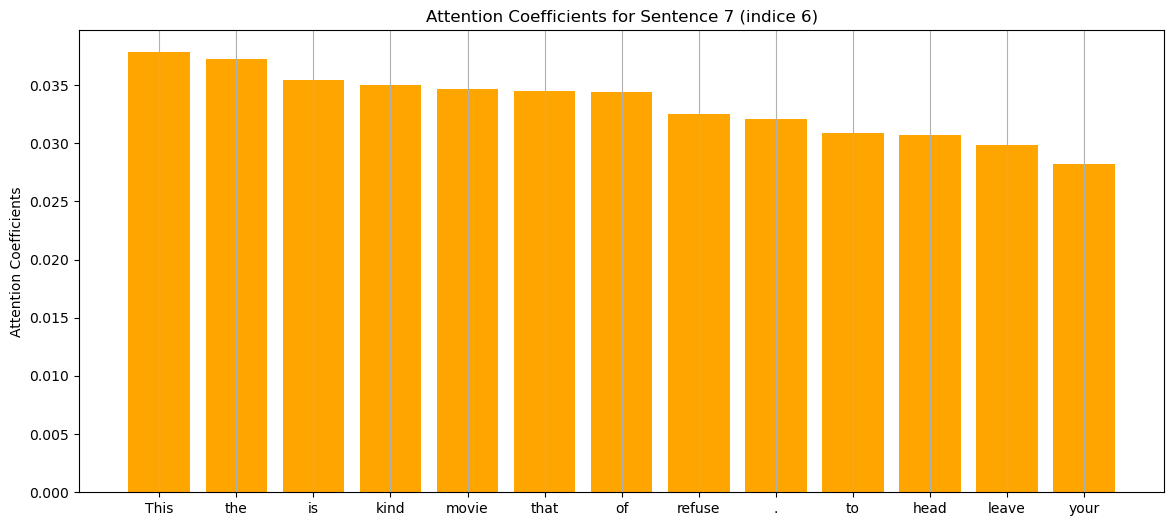

In [95]:
sentence_index = 6 
words, coeffs = zip(*text_word_coeffs_sorted[sentence_index])    # Extract words and their coefficients for the chosen sentence

plt.figure(figsize=(14, 6))
plt.bar(words, coeffs, 
         color='orange')
plt.ylabel('Attention Coefficients')
plt.title(f'Attention Coefficients for Sentence {sentence_index + 1} (indice {sentence_index})')
plt.grid(axis='x')
plt.show()